In [41]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter, FuncFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from scipy.optimize import fsolve

# Definir las constantes
g = 9.8 # gravedad [m/s^2]
p_atm = 101325 # Presión atmosférica [Pa]
beta = 3.67e-3 # Coeficiente de expansion termica [1/K]
lambda_f = 0.04 # Coeficiente de friccion [adimensional]
alpha = 2.2e-5 # Coeficiente de difusividad [m^2/s]
rho_0 = 1.0 # Densidad [kg/m^3]
Cp = 1.012 # Capacidad calorifica [J/(kg K)]
k = 0.024 # Conductividad termica [W/(m K)]
nu = 1.71e-5 # Viscosidad [Pa s]

# Parametros directos
R = 10.0 # Radio de la tuberia [m]
L = 100.0 # Longitud de la tuberia [m]
D = 2 * R # Diametro de la tubería [m]

# Definicion de parametros indirectos
def parametros(D=None, L=None, Delta_T=None, LAMBDA=None, phi=None):
    
    # Calcular LAMBDA si no se proporciona
    if LAMBDA is None:
        LAMBDA = L/D # Relación de aspecto
    
    # Calcular phi si no se proporciona
    if phi is None:
        phi = 1 / (beta * Delta_T)
    
    # Calcula Delta_T
    if Delta_T is None:
        Delta_T =  1/ (beta * phi)

    if D is None:
        if L is None:
            D = 10
            L = LAMBDA * D
        else:
            D = L / LAMBDA

    if L is None:
        if D is None:
            D = 10
            L = LAMBDA * D
        else:
            L = LAMBDA * D    
    h = 1.42 * (Delta_T/L)**(1/4) # coeficiente de transmision de calor por convección (recopilatorio)
    Ri = 2 * rho_0**2 * g * beta * L * Cp**2 * Delta_T /  h**2 # Numero de Richardson
    Ra = rho_0**2 * g * beta * Cp * D**2 * Delta_T / (16 * nu * h) # Numero de Rayleigh
    delta = alpha * h / (L**2 * rho_0 * g * beta * Cp * Delta_T)
    
    return h, phi, Ri, Ra, LAMBDA, delta


def f(v, phi, Ri, Ra, LAMBDA):
    return phi + Ri**-1 * v**2 + Ra**-1 * v - 1 + (v/LAMBDA) * (1 - math.exp(-LAMBDA/v))

def f_prime(v, Ri, Ra, LAMBDA):
    return 2 * Ri**-1 * v + Ra**-1 + (1/LAMBDA) * (1 - (1 + 1/v)*math.exp(-LAMBDA/v))

def newton_raphson(phi, Ri, Ra, LAMBDA, v0=0.1, tol=1e-6, max_iter=100):
    v = v0
    for i in range(max_iter):
        v_new = v - f(v, phi, Ri, Ra, LAMBDA) / f_prime(v, Ri, Ra, LAMBDA)
        if abs(v_new - v) < tol:
            return v_new
        v = v_new
    return v  # Returns the last approximation if it doesn't converge

# Calculo y representación
def calculo_v_temperaturas_presiones(Ra, Ri, phi, delta, LAMBDA):
    # Definición de variables y condiciones iniciales
    M = 256 # Número de puntos en la dirección vertical
    N = 512 # Número de puntos en la dirección temporal
    eta = np.linspace(0, 1, M)  # Coordenada vertical adimensional
    tau = np.linspace(0, 1, N)  # Coordenada temporal adimensional
    deta = (eta[-1] - eta[0])/M
    dtau = (tau[-1] - tau[0])/N 
    v = np.zeros(N)  # Velocidad adimensional
    theta_star = np.zeros((M, N))  # Temperatura adimensional
    xi = np.zeros((M, N)) # Presiones adimensionales

    # Condiciones iniciales
    v[0] = 0.0  # Velocidad inicial cero

    # Simulación numérica
    for t in range(1, N-1):


        # Calculo de la velocidad en el instante i+1 a partir de la presión en eta = 0 del instante anterior:
        v[t] = np.sqrt(Ri * phi * xi[0, t-1])

        # Calculo de las distribuciones de temperatura y presion en el espacio para el instante i+1:
        for x in range(M-1):
            
            dtheta_deta = (theta_star[x+1, t-1] - theta_star[x, t-1]) / deta
            d2theta_deta2 = (theta_star[x+1, t-1] - 2 * theta_star[x, t-1] + theta_star[x-1, t-1]) / deta**2
            theta_star[x, t] = theta_star[x, t-1] + dtau * (- 2  * (v[t] / Ri) * dtheta_deta
                                                + delta * d2theta_deta2
                                                - (2 * LAMBDA / Ri) * (theta_star[x, t-1] - 1))
    
        # Cálculo de la presión
        for x in range(M-1, 0, -1):
            if (x == M-1) or (x == M-2):
                xi[x, t] = 0
            else:
                delta_theta = (theta_star[x+2, t] - theta_star[x+1, t])
                xi[x, t] = 2 * xi[x+1, t] - xi[x+2, t] + phi**-1 * delta_theta

        # Redefinición de v
        v[t] = v[t-1] + dtau * (- phi * (xi[1, t] - xi[0, t]) / deta - Ra**-1 * v[t-1] + theta_star[0, t-1])


    return v, theta_star, xi, eta, tau

# Función para encontrar el exponente común
def find_common_exponent(values):
    return np.floor(np.log10(np.max(np.abs(values)))).astype(int)

# Función para formatear los valores con el exponente correcto
def format_with_exponent(value, exponent):
    if exponent >= 0:
        return f'{value/10**exponent:.2f}'
    else:
        return f'{value*10**abs(exponent):.2f}'

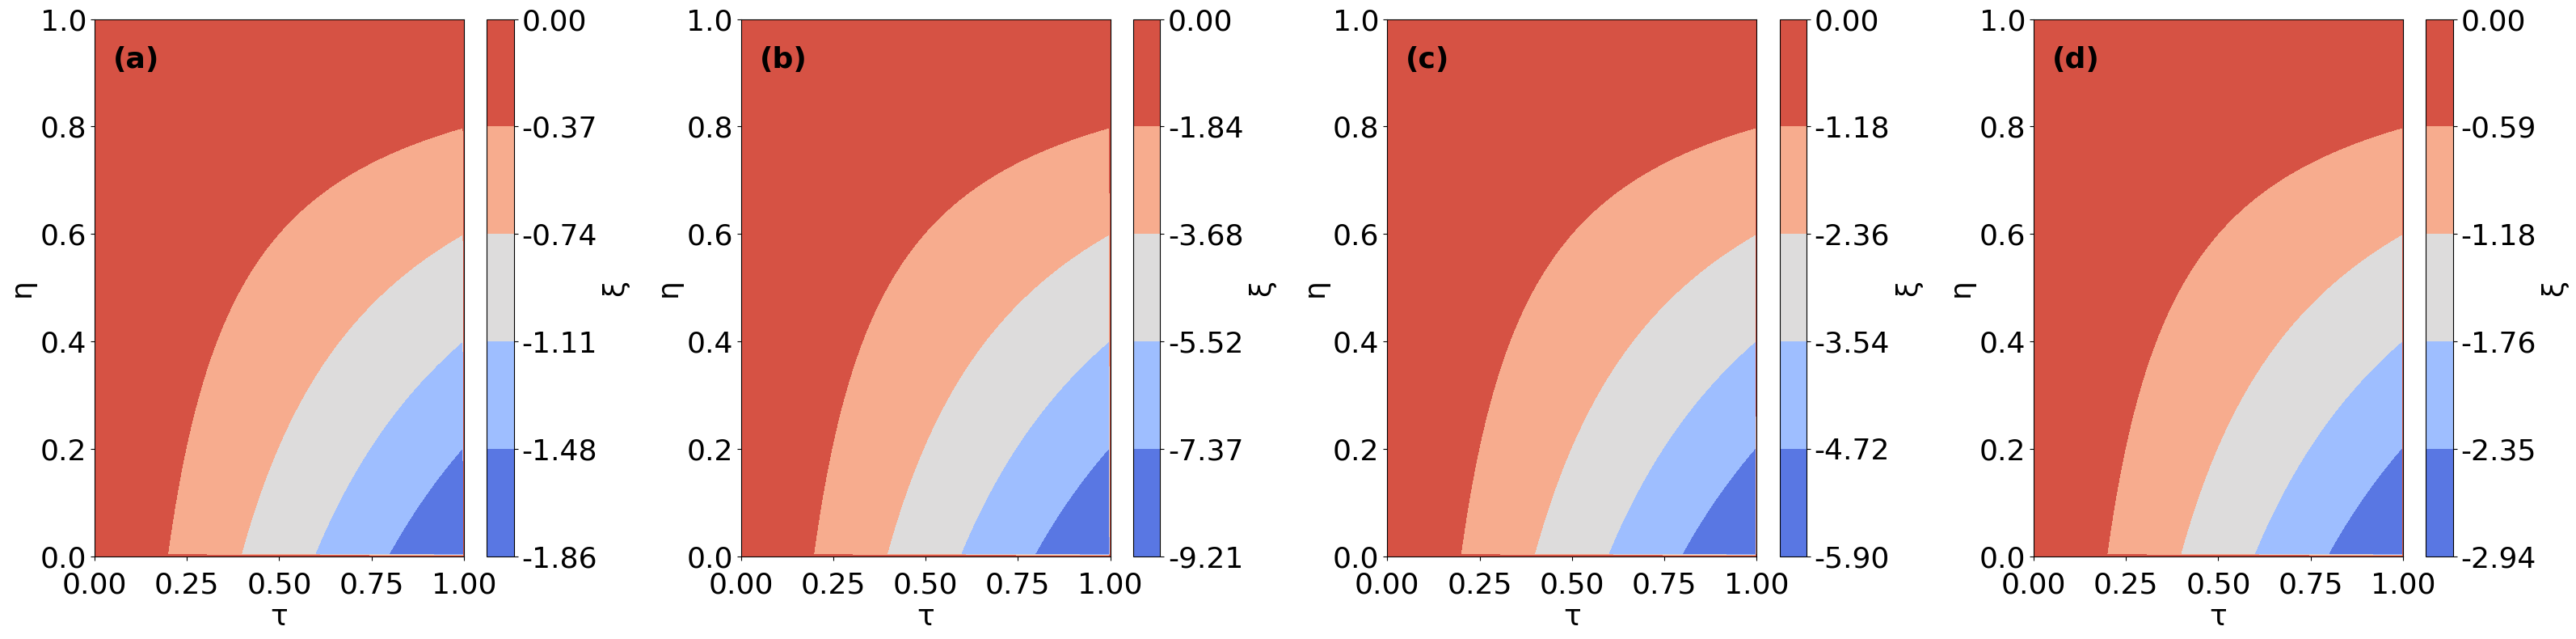

In [42]:
# Casos a estudiar
casos = [
    {"LAMBDA": 10, "phi": 0.2},
    {"LAMBDA": 10, "phi": 0.8},
    {"LAMBDA": 100, "phi": 0.2},
    {"LAMBDA": 100, "phi": 0.8}
]

# Crear una figura con un tamaño específico y una mejor proporción
fig_xi, axs_xi = plt.subplots(1, 4, figsize=(32, 8))  # Aumentado el ancho de la figura y el número de subplots a 4

# Aplanar la matriz de subplots para facilitar la iteración
axs_xi = axs_xi.flatten()

# Definir el número de niveles para las secciones
n_levels = 6

# Graficar y recopilar datos
for i, caso in enumerate(casos):
    LAMBDA = caso["LAMBDA"]
    phi = caso["phi"]
    
    h, _, Ri, Ra, _, delta = parametros(None, None, None, LAMBDA, phi)
    
    v, theta_star, xi, eta, tau = calculo_v_temperaturas_presiones(Ra, Ri, phi, delta, LAMBDA)
    
    # Crear el mapa de calor seccionado para xi
    levels_xi = np.linspace(np.min(xi), np.max(xi), n_levels)
    im_xi = axs_xi[i].contourf(tau, eta, xi, levels=levels_xi, cmap='coolwarm')
    
    # Configurar los ejes y etiquetas para xi
    axs_xi[i].set_xlabel('τ', fontsize=26)
    axs_xi[i].set_ylabel('η', fontsize=26)
    axs_xi[i].set_xlim(0, 1)
    axs_xi[i].set_ylim(0, 1)
    axs_xi[i].tick_params(axis='both', which='major', labelsize=26)
    axs_xi[i].tick_params(axis='x', which='major', pad=10)
    
    # Añadir barra de color para xi con formato personalizado
    cbar_xi = fig_xi.colorbar(im_xi, ax=axs_xi[i], ticks=levels_xi)
    exp_xi = find_common_exponent(levels_xi)
    cbar_xi.ax.set_yticklabels([format_with_exponent(x, exp_xi) for x in levels_xi])
    cbar_xi.set_label('ξ', fontsize=26)
    cbar_xi.ax.tick_params(labelsize=26)
    
    # Añadir etiqueta (a, b, c, d) en la esquina superior izquierda para xi
    axs_xi[i].text(0.05, 0.95, f'({chr(97 + i)})', transform=axs_xi[i].transAxes, 
                   fontsize=26, fontweight='bold', va='top', color='black')

# Ajustar el diseño
plt.tight_layout()

# Añadir espacio entre subplots
plt.subplots_adjust(wspace=0.4)  # Aumentado el espacio entre subplots

# Mostrar la gráfica
plt.show()


Valores de la normalización (v_max, v_min):
945.65 0.0
Valores de la normalización (theta_max, theta_min):
0.03 0.0


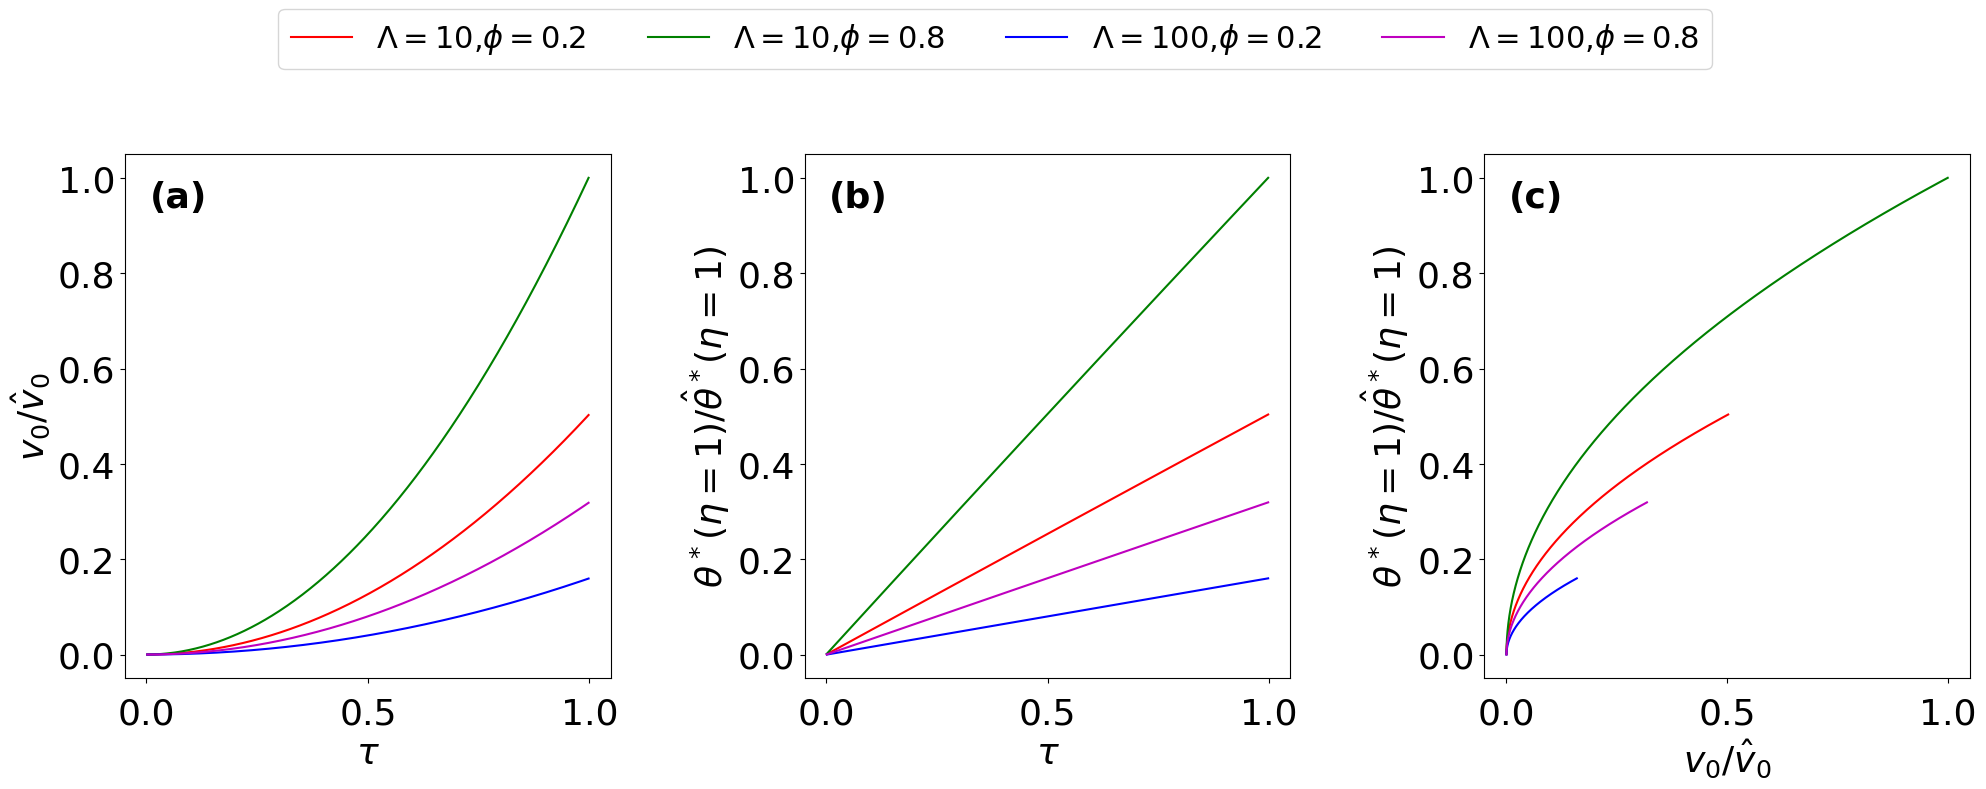

In [47]:
# Casos a estudiar
casos = [
    {"LAMBDA": 10, "phi": 0.2},
    {"LAMBDA": 10, "phi": 0.8},
    {"LAMBDA": 100, "phi": 0.2},
    {"LAMBDA": 100, "phi": 0.8}
]

# Inicializar valores globales
v_global_min, v_global_max = float('inf'), float('-inf')
theta_global_min, theta_global_max = float('inf'), float('-inf')

# Calcular valores globales
for caso in casos:
    LAMBDA = caso["LAMBDA"]
    phi = caso["phi"]
    
    h, _, Ri, Ra, _, delta = parametros(None, None, None, LAMBDA, phi)
    
    v, theta_star, _, eta, tau = calculo_v_temperaturas_presiones(Ra, Ri, phi, delta, LAMBDA)
    
    v_global_min = min(v_global_min, np.min(v))
    v_global_max = max(v_global_max, np.max(v))
    theta_global_min = min(theta_global_min, np.min(theta_star))
    theta_global_max = max(theta_global_max, np.max(theta_star))

# Crear una figura con tres subplots en una fila
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
plt.subplots_adjust(wspace=0.4, hspace=0.1)

# Definir colores y estilos de línea
colores = ['r', 'g', 'b', 'm']
estilos = ['-', '-', '-', '-']

# Graficar y normalizar
for i, caso in enumerate(casos):
    LAMBDA = caso["LAMBDA"]
    phi = caso["phi"]
    
    h, _, Ri, Ra, _, delta = parametros(None, None, None, LAMBDA, phi)
    
    v, theta_star, _, eta, tau = calculo_v_temperaturas_presiones(Ra, Ri, phi, delta, LAMBDA)
    
    # Normalización global de v y theta
    v_normalized = (v - v_global_min) / (v_global_max - v_global_min)
    theta_normalized = (theta_star - theta_global_min) / (theta_global_max - theta_global_min)

    # a) v_0 vs. tau
    axs[0].plot(tau[1:-1], v_normalized[1:-1], color=colores[i], linestyle=estilos[i], 
                label=r'$\Lambda =$'f'{LAMBDA},'r'$\phi =$' f'{phi}')
    
    # b) theta(eta = 1, tau) vs. tau
    axs[1].plot(tau[1:-1], theta_normalized[-2, 1:-1], color=colores[i], linestyle=estilos[i])

    # c) v_0(tau) vs. theta(eta = 1, tau)
    axs[2].plot(v_normalized[1:-1], theta_normalized[-2, 1:-1], color=colores[i], linestyle=estilos[i])

print('Valores de la normalización (v_max, v_min):')
print(round(v_global_max, 2), round(v_global_min,2))

print('Valores de la normalización (theta_max, theta_min):')
print(round(theta_global_max, 2), round(theta_global_min, 2))

# Configurar los subplots
y_labels = [r'$v_0 / \hat{v}_0$', r'$\theta^*(\eta = 1) / \hat{\theta}^*(\eta = 1)$', r'$\theta^*(\eta = 1) / \hat{\theta}^*(\eta = 1)$']
x_labels = [r'$\tau$', r'$\tau$', r'$v_0 / \hat{v}_0$'] 

for i, (ax, ylabel, xlabel) in enumerate(zip(axs, y_labels, x_labels)):
    ax.set_xlabel(xlabel, fontsize=26)
    ax.set_ylabel(ylabel, fontsize=26)
    ax.tick_params(axis='both', which='major', labelsize=26)
    ax.tick_params(axis='x', which='major', pad=10)
    
    # Añadir etiqueta (a, b, c) en la esquina superior izquierda
    ax.text(0.05, 0.95, f'({chr(97 + i)})', transform=ax.transAxes, 
            fontsize=26, fontweight='bold', va='top', ha='left')

# Añadir una leyenda común
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1),
           ncol=4, fontsize=22)

# Ajustar el diseño
plt.tight_layout()
fig.subplots_adjust(top=0.8, wspace=0.4)

# Mostrar la gráfica
plt.show()
